In [1]:
!pip install gymnasium
!pip install torch

--

Environment Description

CartPole-v1 : https://gymnasium.farama.org/environments/classic_control/cart_pole/

Acrobot-v1 : https://gymnasium.farama.org/environments/classic_control/acrobot/

MountainCar-v0 : https://gymnasium.farama.org/environments/classic_control/mountain_car/

--

In [2]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")



---



## 1. DQN Implemetation

In [3]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # Define a single hidden layer network
        self.fc1 = nn.Linear(state_dim, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, action_dim)  # Output layer

    def forward(self, s):
        # Pass the input through the layers with ReLU activation
        x = torch.relu(self.fc1(s))
        q = self.fc2(x)  # Output layer without activation
        return q

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device

        # Do not modify these hyper-parameters
        self.Epochs = 1000
        self.discount_factor = 0.98
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_min = 0.001
        self.batch_size = 256
        self.train_start = self.batch_size * 5
        self.memory = deque(maxlen=100000)

        # You can modify this depending on environments.
        self.epsilon_decay_rate = 0.995

        # Define and initialize your networks and optimizer
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def get_action(self, state, use_epsilon_greedy=True):
        if use_epsilon_greedy and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state)
            return torch.argmax(q_values).item()

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_samples(self, n):
        samples = random.sample(self.memory, n)
        states, actions, rewards, next_states, dones = zip(*samples)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        return states, actions, rewards, next_states, dones

    def epsilon_decay(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay_rate

    def train(self):
        if len(self.memory) < self.train_start:
            return None

        s_batch, a_batch, r_batch, s_next_batch, done_batch = self.get_samples(self.batch_size)

        q_values = self.q_network(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(s_next_batch).max(1)[0]
        target_q_values = r_batch + (self.discount_factor * next_q_values * (1 - done_batch))

        loss = nn.MSELoss()(q_values, target_q_values.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon_decay()

        return loss.item()

In [5]:
# Do not modify this cell
def evaluation(env, agent):
    done, episode_score, episode_steps = False, 0.0, 0

    state, _ = env.reset()
    for t in range(env._max_episode_steps):
        action = agent.get_action(state, use_epsilon_greedy=False)
        state_next, reward, done, time_truncation, _ = env.step(action)

        episode_score += reward
        episode_steps += 1

        state = state_next
        if done:
            break

    return episode_score, episode_steps


In [6]:
# experiments envs : "CartPole-v1", "Acrobot-v1", "MountainCar-v0"

env_name          = "MountainCar-v0"

In [7]:
# Do not modify this cell

env               = gym.make(env_name)
state_size        = env.observation_space.shape[0]
action_size       = env.action_space.n
max_episode_steps = env._max_episode_steps
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("state_size:{}, action_size:{}, max_episode_steps:{}, device:{} \n".format(state_size, action_size, max_episode_steps, device))

agent = DQNAgent(state_size, action_size, device)



episode_scores_list, episode_steps_list = [], []
for epoch in range(agent.Epochs):  # agent.Epochs = 1000

    state, _ = env.reset()
    for t in range(max_episode_steps):
        action = agent.get_action(state)
        state_next, reward, done, time_truncation, _ = env.step(action)

        agent.append_sample(state, action, reward, state_next, done)

        if len(agent.memory) >= agent.train_start:
            agent.train()

        state = state_next
        if done:
            state, _ = env.reset()

    agent.update_target_network()
    agent.epsilon_decay()

    episode_score, episode_steps = evaluation(env, agent)
    episode_scores_list.append(episode_score)
    episode_steps_list.append(episode_steps)

    if epoch % 10 == 0:
        print("Epoch:{}, Episode_score:{}, Episode_steps:{}, epsilon:{}".format(epoch, episode_score, episode_steps, agent.epsilon))



state_size:2, action_size:3, max_episode_steps:200, device:cuda 

Epoch:0, Episode_score:-200.0, Episode_steps:200, epsilon:0.995
Epoch:10, Episode_score:-200.0, Episode_steps:200, epsilon:0.009356453315889223
Epoch:20, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:30, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:40, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:50, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:60, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:70, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:80, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:90, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:100, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:110, Episode_score:-200.0, Episode_steps:200, epsilon:

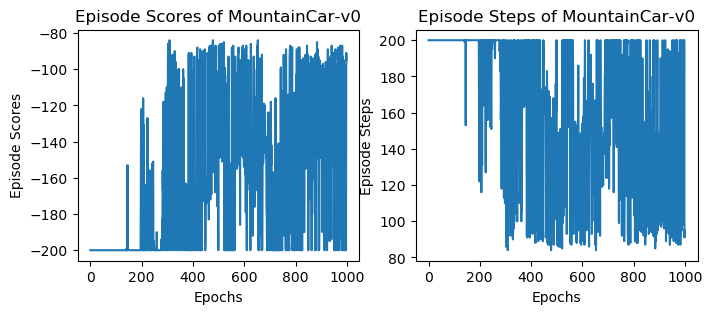

In [8]:
# This cell provides basic evaluation score graph. You can add more plots.

plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(episode_scores_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Scores")
plt.title("Episode Scores of {}".format(env_name))

plt.subplot(1,2,2)
plt.plot(episode_steps_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Steps")
plt.title("Episode Steps of {}".format(env_name))

plt.show()



---



## 2. Double DQN implemantation

In [9]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # Define a single hidden layer network
        self.fc1 = nn.Linear(state_dim, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, action_dim)  # Output layer

    def forward(self, s):
        # Pass the input through the layers with ReLU activation
        x = torch.relu(self.fc1(s))
        q = self.fc2(x)  # Output layer without activation
        return q

In [10]:
class DoubleDQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size         = state_size
        self.action_size        = action_size
        self.device             = device

        # Do not modify these hyper-parameters
        self.Epochs             = 1000
        self.discount_factor    = 0.98
        self.learning_rate      = 0.001  # learning rate for q function
        self.epsilon            = 1.0    # initial epsilon value
        self.epsilon_min        = 0.001  # minimum epsilon value
        self.batch_size         = 256
        self.train_start        = self.batch_size * 5
        self.memory             = deque(maxlen=100000)  # replay memory

        # You can modify this depending on environments.
        self.epsilon_decay_rate = 0.995   # decay rate

        # Define and initialize your networks and optimizer
        self.q_network = QNetwork(state_size, action_size).to(self.device)
        self.target_network = QNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.update_target_network()


    def update_target_network(self):
        # implement target Q network update function
        self.target_network.load_state_dict(self.q_network.state_dict())


    def get_action(self, state, use_epsilon_greedy=True):
        if use_epsilon_greedy:
            if np.random.rand() <= self.epsilon:
                return random.randrange(self.action_size)
            else:
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_network(state)
                return np.argmax(q_values.cpu().data.numpy())
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state)
            return np.argmax(q_values.cpu().data.numpy())

    def append_sample(self, state, action, reward, next_state, done):
        # implement storing function given (s,a,r,s',done) into the replay memory.
        self.memory.append((state, action, reward, next_state, done))
        
    def get_samples(self, n):
        # implement transition random sampling function from the replay memory,
        # and make the transiton to batch.
        minibatch = random.sample(self.memory, n)
        s_batch = np.array([sample[0] for sample in minibatch])
        a_batch = np.array([sample[1] for sample in minibatch])
        r_batch = np.array([sample[2] for sample in minibatch])
        s_next_batch = np.array([sample[3] for sample in minibatch])
        done_batch = np.array([sample[4] for sample in minibatch])
        # i.e.) s_batch : (batch_size, state_dim)
        
        return s_batch, a_batch, r_batch, s_next_batch, done_batch
        

    def epsilon_decay(self):
        # implement epsilon decaying function that
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay_rate
            
    def train(self):
        if len(self.memory) < self.train_start:
            return None

        s_batch, a_batch, r_batch, s_next_batch, done_batch = self.get_samples(self.batch_size)

        s_batch = torch.FloatTensor(s_batch).to(self.device)
        a_batch = torch.LongTensor(a_batch).unsqueeze(1).to(self.device)
        r_batch = torch.FloatTensor(r_batch).to(self.device)
        s_next_batch = torch.FloatTensor(s_next_batch).to(self.device)
        done_batch = torch.FloatTensor(done_batch).to(self.device)

        # Current Q values
        q_values = self.q_network(s_batch).gather(1, a_batch).squeeze(1)

        # Next Q values using Double DQN
        next_actions = self.q_network(s_next_batch).max(1)[1].unsqueeze(1)
        next_q_values = self.target_network(s_next_batch).gather(1, next_actions).squeeze(1)
        
        # Target Q values
        target_q_values = r_batch + (self.discount_factor * next_q_values * (1 - done_batch))

        # Loss
        loss = nn.MSELoss()(q_values, target_q_values.detach())

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon_decay()

        # Optionally return statistics
        return loss.item()



In [11]:
# Do not modify this cell
def evaluation(env, agent):
    done, episode_score, episode_steps = False, 0.0, 0

    state, _ = env.reset()
    for t in range(env._max_episode_steps):
        action = agent.get_action(state, use_epsilon_greedy=False)
        state_next, reward, done, time_truncation, _ = env.step(action)

        episode_score += reward
        episode_steps += 1

        state = state_next
        if done:
            break

    return episode_score, episode_steps


In [12]:
# experiments envs : "CartPole-v1", "Acrobot-v1", "MountainCar-v0"

env_name          = "MountainCar-v0"

In [13]:
# Do not modify this cell

env               = gym.make(env_name)
state_size        = env.observation_space.shape[0]
action_size       = env.action_space.n
max_episode_steps = env._max_episode_steps
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("state_size:{}, action_size:{}, max_episode_steps:{}, device:{} \n".format(state_size, action_size, max_episode_steps, device))

agent = DoubleDQNAgent(state_size, action_size, device)



episode_scores_list, episode_steps_list = [], []
for epoch in range(agent.Epochs):  # agent.Epochs = 1000

    state, _ = env.reset()
    for t in range(max_episode_steps):
        action = agent.get_action(state)
        state_next, reward, done, time_truncation, _ = env.step(action)

        agent.append_sample(state, action, reward, state_next, done)

        if len(agent.memory) >= agent.train_start:
            agent.train()

        state = state_next
        if done:
            state, _ = env.reset()

    agent.update_target_network()
    agent.epsilon_decay()

    episode_score, episode_steps = evaluation(env, agent)
    episode_scores_list.append(episode_score)
    episode_steps_list.append(episode_steps)

    if epoch % 10 == 0:
        print("Epoch:{}, Episode_score:{}, Episode_steps:{}, epsilon:{}".format(epoch, episode_score, episode_steps, agent.epsilon))



state_size:2, action_size:3, max_episode_steps:200, device:cuda 

Epoch:0, Episode_score:-200.0, Episode_steps:200, epsilon:0.995
Epoch:10, Episode_score:-200.0, Episode_steps:200, epsilon:0.009356453315889223
Epoch:20, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:30, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:40, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:50, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:60, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:70, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:80, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:90, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:100, Episode_score:-200.0, Episode_steps:200, epsilon:0.0009954703940636294
Epoch:110, Episode_score:-200.0, Episode_steps:200, epsilon:

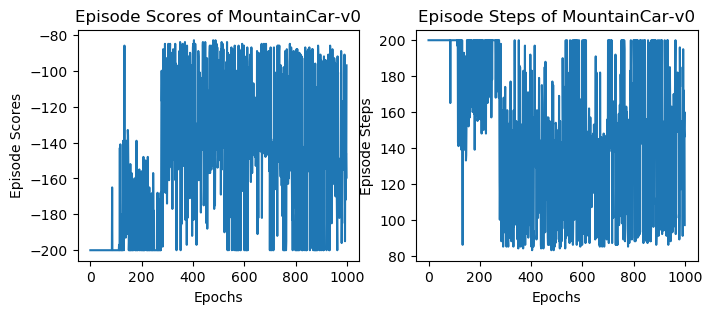

In [14]:
# This cell provides basic evaluation score graph. You can add more plots.

plt.figure(figsize=(8, 3))

plt.subplot(1,2,1)
plt.plot(episode_scores_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Scores")
plt.title("Episode Scores of {}".format(env_name))

plt.subplot(1,2,2)
plt.plot(episode_steps_list)
plt.xlabel("Epochs")
plt.ylabel("Episode Steps")
plt.title("Episode Steps of {}".format(env_name))

plt.show()



---



## 3. Additional Implementation

In [ ]:
# You can implement any RL algorithm that could increase performance, but experiment on the three environments.